In [1]:
import pandas as pd
import numpy as np
import pickle
import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
import statsmodels.api as sm
# import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [2]:
with open('finalgamedf.pkl', 'rb') as read_file:
    game_df = pickle.load(read_file)

In [3]:
with open('nmfdf2.pkl', 'rb') as read_file:
    topic_df = pickle.load(read_file)

In [299]:
game_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17046 entries, 0 to 17045
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   yearpublished                  17046 non-null  float64 
 1   minplayers                     17046 non-null  float64 
 2   maxplayers                     17046 non-null  float64 
 3   minplaytime                    17046 non-null  float64 
 4   maxplaytime                    17046 non-null  float64 
 5   minage                         17046 non-null  float64 
 6   playerage                      17046 non-null  object  
 7   languagedependence             17046 non-null  float64 
 8   avgweight                      17046 non-null  float64 
 9   numweights                     17046 non-null  float64 
 10  numgeeklists                   17046 non-null  float64 
 11  news                           17046 non-null  float64 
 12  blogs                          1

### Merge game attributes with topic dataframe

In [4]:
df = pd.merge(game_df,topic_df, how='left',left_on='id',right_index=True,left_index=False)

In [5]:
df = df.drop(columns=['primary','median','playerage','podcast','boardgamedesigner', 'boardgameartist',
       'boardgamepublisher', 'Rank','boardgamecategory','siteviews','numgeeklists','conv_rate','blogs','news','weblink','podcast',
        'boardgamemechanic' ,'boardgamepublisher_cnt','yearpublished','Rank',
        'maxplayers','minplaytime','maxplaytime','Expansion for Base-game','Pirates',
        'Collectible Components','Storytelling','Dice','Card Game','Simulation','Pattern Building',
        'Party Game','Political','Animals','Frank Chadwick','Jim Dunnigan','Joseph Miranda','Klaus Teuber',
        'American West','Dean Essig','Electronic','Memory','Novel-based','World War II','Video Game Theme',
        'minage','Puzzle','Industry / Manufacturing','Aviation / Flight'])

In [6]:
# remove a few large outliers titled - "Outside Scope of BGG" , "Unpublished Prototype","Miscellaneous Accessory"
outliers_id = [23953.0,4249.0,5985.0,18291.0]
df = df[~df.id.isin(outliers_id)]

In [7]:
df = df.dropna(axis=0)

In [2281]:
smaller_df = df[['owned','minplayers','languagedependence','boardgamedesigner_cnt','boardgameartist_cnt',
               'boardgamecategory_cnt','boardgamemechanic_cnt','average','averageweight','stddev',
               'avg_time','action_top', 'battle_top', 'card_top', 'dice_top', 'party_top',
       'abstract_top', 'tile_top', 'fam_top', 'charac_top']]
correlations = smaller_df.corr()

correlations['owned']

owned                    1.000000
minplayers              -0.032487
languagedependence       0.281869
boardgamedesigner_cnt    0.078354
boardgameartist_cnt      0.134276
boardgamecategory_cnt    0.137814
boardgamemechanic_cnt    0.355407
average                  0.296525
averageweight            0.216718
stddev                  -0.246845
avg_time                 0.012176
action_top               0.364409
battle_top               0.033132
card_top                 0.182035
dice_top                 0.081343
party_top                0.034197
abstract_top            -0.004932
tile_top                 0.114029
fam_top                 -0.013686
charac_top               0.345254
Name: owned, dtype: float64

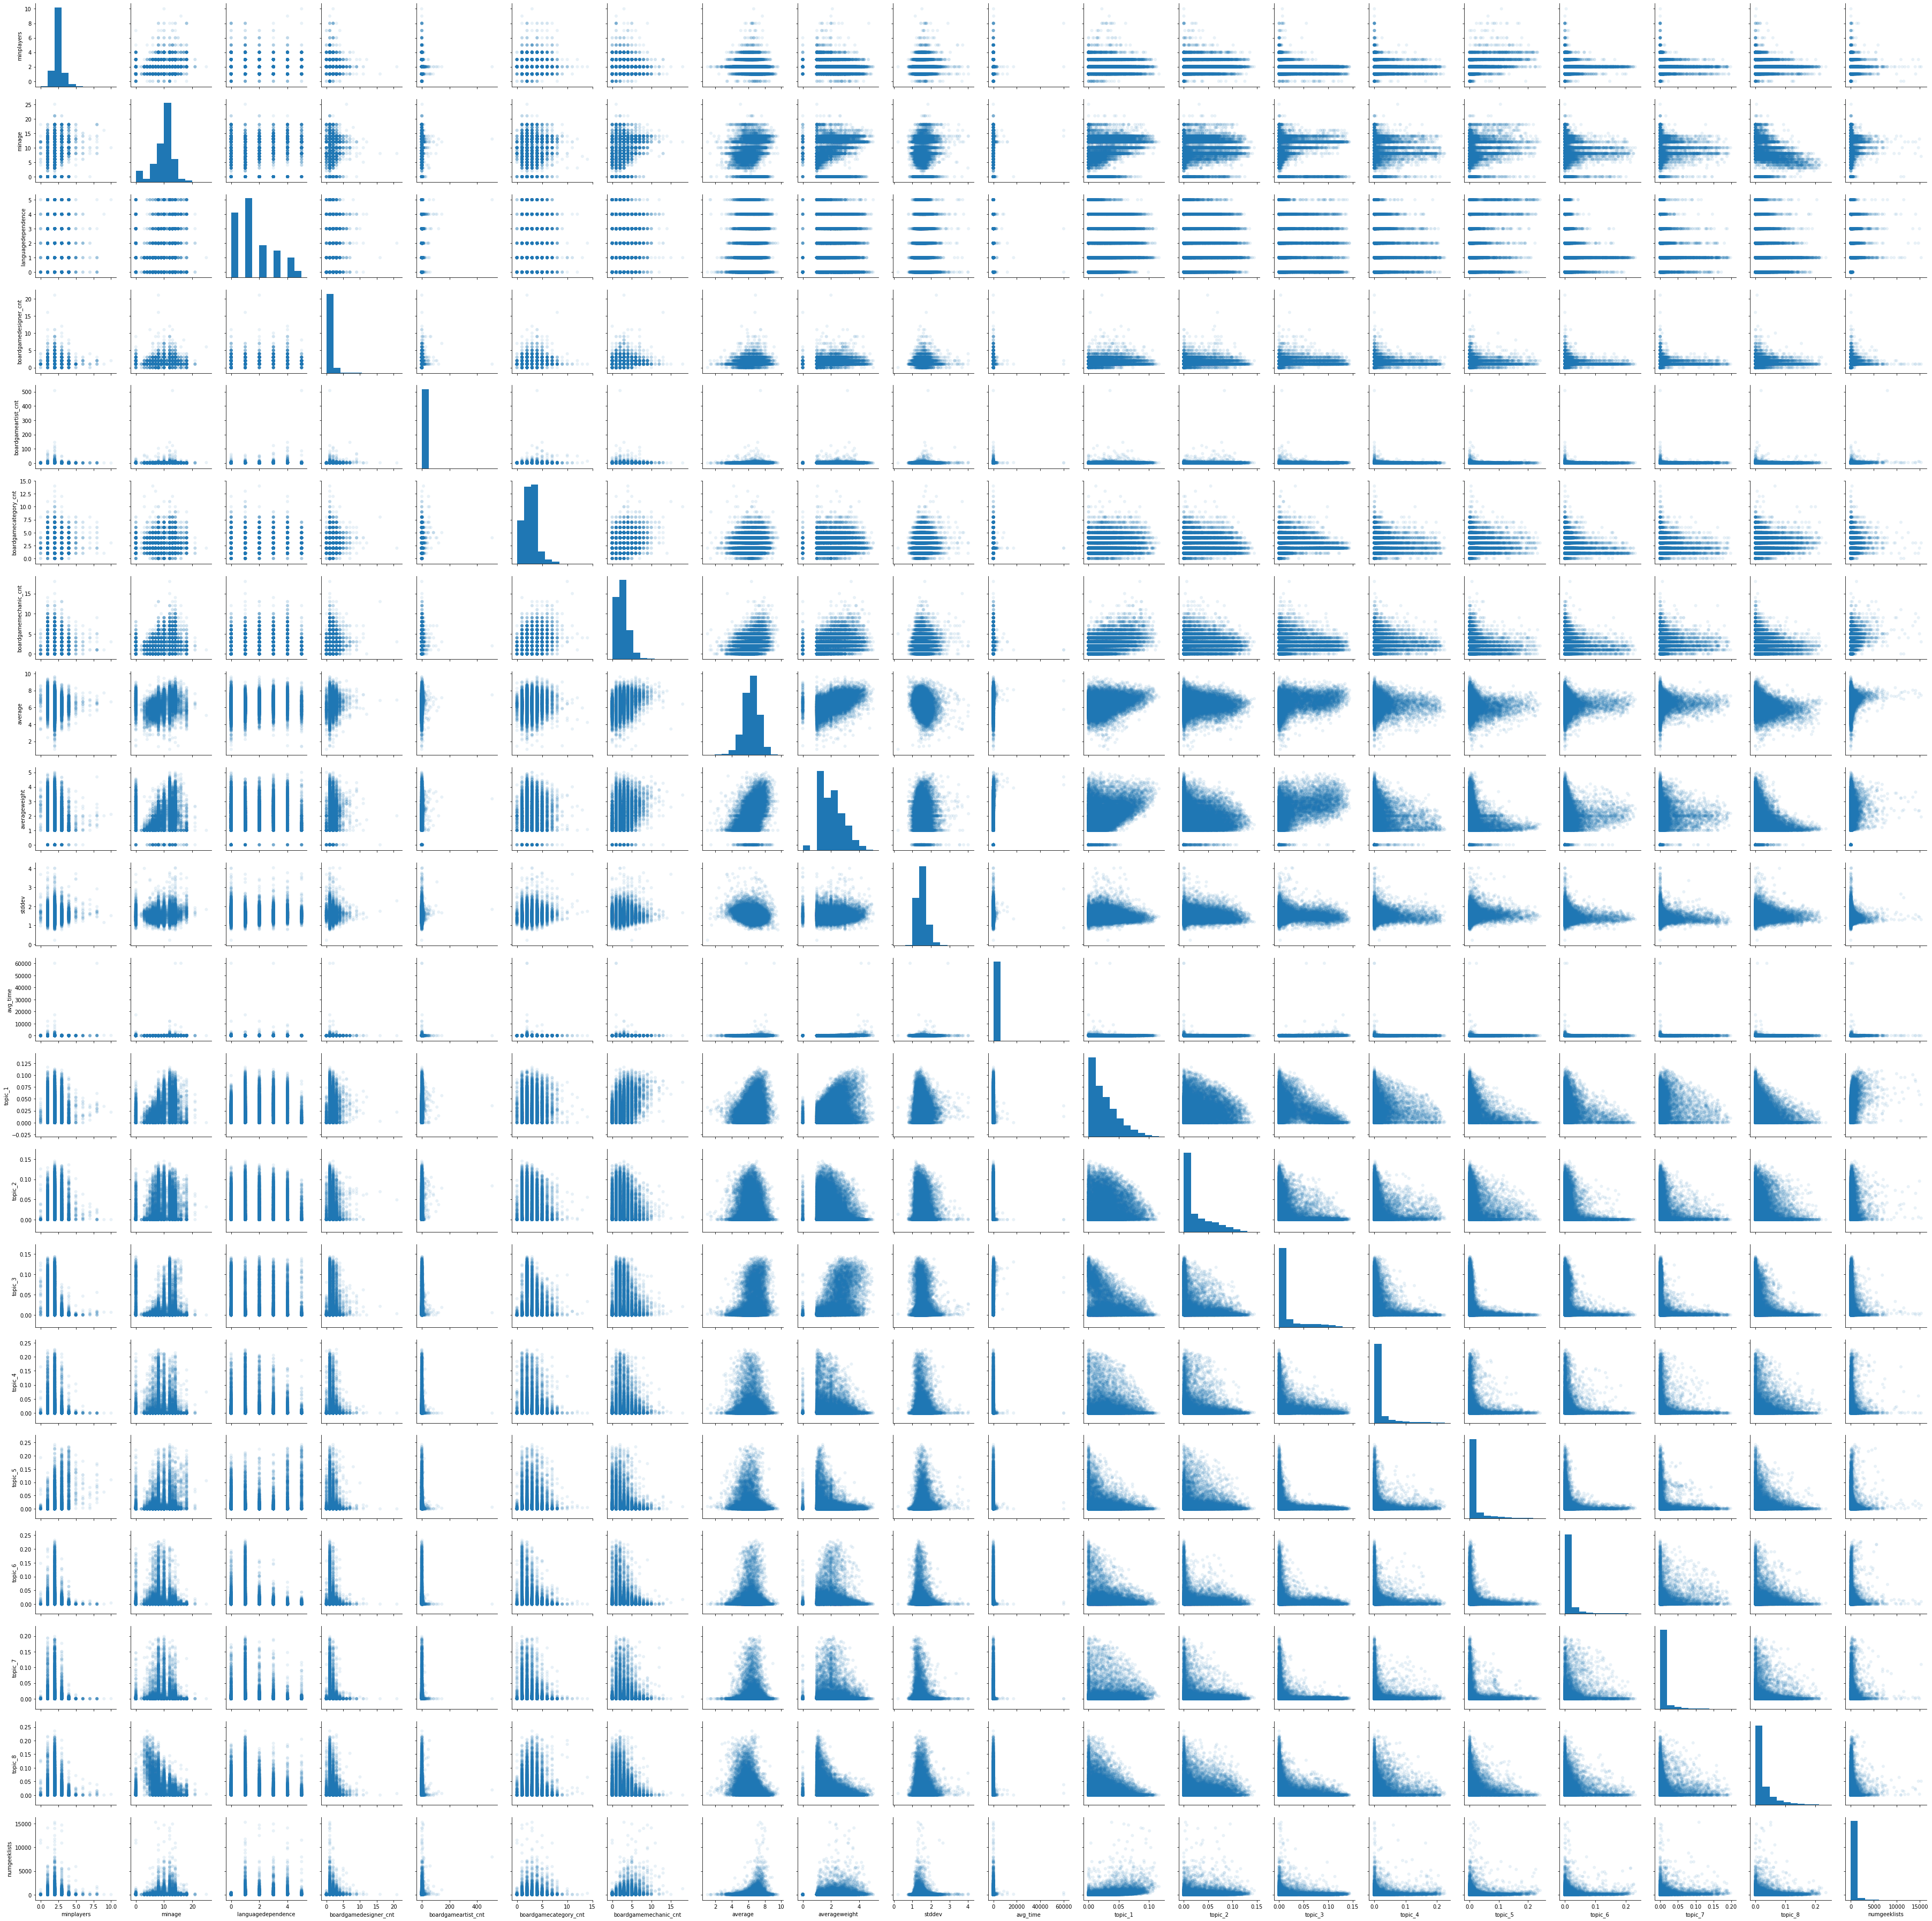

In [585]:
sns.pairplot(smaller_df, plot_kws=dict(alpha=.1, edgecolor='none'))

# Remove Outliers - Log Transform Target

In [2236]:
q1 = df['owned'].quantile(.25)
q3 = df['owned'].quantile(.75)
iqr = q3 - q1

lower_bound = q1 -(1 * iqr) 
upper_bound = 25000

quartile_mask = df['owned'].between(lower_bound, upper_bound, inclusive=True)
allowed_idx = df.loc[quartile_mask, 'owned'].index
df = df[df.index.isin(allowed_idx)]

In [2149]:
print(q1, q3)
print(lower_bound, upper_bound)

144.0 809.0
-521.0 6129.0


In [8]:
# log_cols = ['languagedependence','boardgamedesigner_cnt','boardgameartist_cnt',
#                'boardgamecategory_cnt','boardgamemechanic_cnt',
#                'numgeeklists']

# for col in log_cols:
#     if col == 'numgeeklists':
#         df[col] = np.log(df[col] + 1)
#     else:
#         df[col] = np.log(df[col]+1)
# df['numgeeklists'] = np.log(df['numgeeklists']+1)
df['owned'] = np.log(df['owned'])

# Train Test Split

In [9]:
# creating target variable and train data (first tried numlists, then owned)
# X = df.drop(columns=['id','numgeeklists','bayesaverage','wanting','wishing'], axis=1)
# y = df['numgeeklists']
X = df.drop(columns=['id','owned','bayesaverage','wanting','wishing'], axis=1)
y = df['owned']

In [10]:
print(X.shape)
print(y.shape)

(17029, 94)
(17029,)


In [11]:
# Splitting the above into testing and training arrays
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

## Standardization

In [12]:
#scale only the non-categorical columns - StandardScaler
scaled_cols = ['minplayers','boardgamedesigner_cnt','boardgameartist_cnt','stddev','playingtime','avg_time','avg_players',
               'boardgamecategory_cnt','boardgamemechanic_cnt','average','averageweight','languagedependence',
               'action_top', 'battle_top', 'card_top', 'dice_top', 'party_top','abstract_top', 'tile_top',
               'fam_top', 'charac_top']

cat_cols = X_train.columns[~X_train.columns.isin(scaled_cols)]

scaler = StandardScaler()

#drop the columns to be scaled to make reassigning easier
X_train, scaled_train_cols = X_train.drop(columns = scaled_cols), \
                                scaler.fit_transform(X_train[scaled_cols])

X_val, scaled_val_cols = X_val.drop(columns = scaled_cols), \
                                scaler.transform(X_val[scaled_cols])

X_test, scaled_test_cols = X_test.drop(columns = scaled_cols), \
                                scaler.transform(X_test[scaled_cols])

#recreate the columns with the scaled values
#while making sure to reassign at the correct index
X_train[scaled_cols] = pd.DataFrame(scaled_train_cols,
                                    index = X_train.index,
                                    columns = scaled_cols)

X_val[scaled_cols] = pd.DataFrame(scaled_val_cols,
                                   index = X_val.index,
                                   columns = scaled_cols)

X_test[scaled_cols] = pd.DataFrame(scaled_test_cols,
                                   index = X_test.index,
                                   columns = scaled_cols)

In [13]:
# add intercept for modeling
X_train = sm.add_constant(X_train, has_constant='add') 
X_val = sm.add_constant(X_val, has_constant='add')
X_test = sm.add_constant(X_test, has_constant='add') 

## OLS

In [14]:
# with numgeeklists at target
model = sm.OLS(y_train, X_train)

fit = model.fit()

y_pred = fit.predict(X_val)
print('R^2 Score for Test: ' + str(round(r2_score(y_val, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.63


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  owned   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     179.4
Date:                Mon, 30 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:09:34   Log-Likelihood:                -12455.
No. Observations:               10217   AIC:                         2.510e+04
Df Residuals:                   10122   BIC:                         2.579e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             6.0142      0.029    208.092      0.000       5.958       6.071
Bruno Cathala                     0.3253      0.120      2.706      0.007       0.090       0.561
James Ernest                      0.4854      0.116      4.195      0.000       0.259       0.712
Martin Wallace                    0.0624      0.122      0.512      0.609      -0.176       0.301
Michael Schacht                   0.1732      0.123      1.410      0.158      -0.068       0.414
Reiner Knizia                     0.1299      0.064      2.040      0.041       0.005       0.255
Richard H Berg                   -0.0066      0.108     -0.061      0.951      -0.218       0.205
Wolfgang Kramer                   0.0938      0.099      0.946      0.344      -0.101       0.288
Wargame                           0.0891      0.045      1.976      0.048       0.001       0.177
Fantasy                          -0.0155      0.030     -0.516      0.606      -0.074       0.043
Fighting                         -0.0852      0.036     -2.354      0.019      -0.156      -0.014
Abstract Strategy                -0.1399      0.047     -2.995      0.003      -0.231      -0.048
Childrens Game                   -0.0989      0.042     -2.350      0.019      -0.181      -0.016
Science Fiction                  -0.0292      0.035     -0.824      0.410      -0.099       0.040
Economic                          0.0677      0.039      1.746      0.081      -0.008       0.144
Bluffing                         -0.0239      0.040     -0.590      0.555      -0.103       0.055
Humor                             0.0236      0.040      0.594      0.552      -0.054       0.101
Deduction                         0.1795      0.044      4.057      0.000       0.093       0.266
Adventure                        -0.2224      0.043     -5.156      0.000      -0.307      -0.138
Action / Dexterity               -0.0073      0.041     -0.178      0.859      -0.088       0.073
Movies / TV / Radio theme         0.1823      0.042      4.348      0.000       0.100       0.264
Trivia                            0.1227      0.058      2.123      0.034       0.009       0.236
City Building                     0.2150      0.058      3.723      0.000       0.102       0.328
Word Game                         0.1131      0.066      1.716      0.086      -0.016       0.242
Print & Play                     -0.6188      0.056    -11.126      0.000      -0.728      -0.510
Educational                      -0.0835      0.059     -1.413      0.158      -0.199       0.032
Territory Building                0.2540      0.061      4.194      0.000       0.135       0.373
Transportation                    0.0255      0.073      0.349      0.727      -0.118       0.169
Modern Warfare                    0.1063     

In [2356]:
# with owned as target
model = sm.OLS(y_train, X_train)

fit = model.fit()

y_pred = fit.predict(X_val)
print('R^2 Score for Test: ' + str(round(r2_score(y_val, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.63


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  owned   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     179.4
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:30:36   Log-Likelihood:                -12455.
No. Observations:               10217   AIC:                         2.510e+04
Df Residuals:                   10122   BIC:                         2.579e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             6.0142      0.029    208.092      0.000       5.958       6.071
Bruno Cathala                     0.3253      0.120      2.706      0.007       0.090       0.561
James Ernest                      0.4854      0.116      4.195      0.000       0.259       0.712
Martin Wallace                    0.0624      0.122      0.512      0.609      -0.176       0.301
Michael Schacht                   0.1732      0.123      1.410      0.158      -0.068       0.414
Reiner Knizia                     0.1299      0.064      2.040      0.041       0.005       0.255
Richard H Berg                   -0.0066      0.108     -0.061      0.951      -0.218       0.205
Wolfgang Kramer                   0.0938      0.099      0.946      0.344      -0.101       0.288
Wargame                           0.0891      0.045      1.976      0.048       0.001       0.177
Fantasy                          -0.0155      0.030     -0.516      0.606      -0.074       0.043
Fighting                         -0.0852      0.036     -2.354      0.019      -0.156      -0.014
Abstract Strategy                -0.1399      0.047     -2.995      0.003      -0.231      -0.048
Childrens Game                   -0.0989      0.042     -2.350      0.019      -0.181      -0.016
Science Fiction                  -0.0292      0.035     -0.824      0.410      -0.099       0.040
Economic                          0.0677      0.039      1.746      0.081      -0.008       0.144
Bluffing                         -0.0239      0.040     -0.590      0.555      -0.103       0.055
Humor                             0.0236      0.040      0.594      0.552      -0.054       0.101
Deduction                         0.1795      0.044      4.057      0.000       0.093       0.266
Adventure                        -0.2224      0.043     -5.156      0.000      -0.307      -0.138
Action / Dexterity               -0.0073      0.041     -0.178      0.859      -0.088       0.073
Movies / TV / Radio theme         0.1823      0.042      4.348      0.000       0.100       0.264
Trivia                            0.1227      0.058      2.123      0.034       0.009       0.236
City Building                     0.2150      0.058      3.723      0.000       0.102       0.328
Word Game                         0.1131      0.066      1.716      0.086      -0.016       0.242
Print & Play                     -0.6188      0.056    -11.126      0.000      -0.728      -0.510
Educational                      -0.0835      0.059     -1.413      0.158      -0.199       0.032
Territory Building                0.2540      0.061      4.194      0.000       0.135       0.373
Transportation                    0.0255      0.073      0.349      0.727      -0.118       0.169
Modern Warfare                    0.1063     

In [2338]:
# scaler with MinMaxScaler - scale data 0 to 1
mm_scaler = MinMaxScaler()
X_train_minmax = mm_scaler.fit_transform(X_train)
#only fit_transform on train set, transform on test
X_val_minmax = mm_scaler.transform(X_val)

In [2340]:
mm_model = sm.OLS(y_train, X_train_minmax)
mm_fit = mm_model.fit()

y_pred_mm = mm_fit.predict(X_val_minmax)
print('R^2 Score for Test: ' + str(round(r2_score(y_val, y_pred_mm), 2)))

mm_fit.summary()

R^2 Score for Test: 0.58


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  owned   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              5120.
Date:                Tue, 24 Mar 2020   Prob (F-statistic):                        0.00
Time:                        22:07:39   Log-Likelihood:                         -13112.
No. Observations:               10217   AIC:                                  2.641e+04
Df Residuals:                   10123   BIC:                                  2.709e+04
Df Model:                          94                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.22e-17   1.51e-17     -2.788      0.005   -7.19e-17   -1.25e-17
x1             1.5588      0.133     11.737      0.000       1.298       1.819
x2             0.4024      0.036     11.186      0.000       0.332       0.473
x3             0.5207      0.135      3.843      0.000       0.255       0.786
x4             3.7710      0.738      5.107      0.000       2.324       5.218
x5             0.2601      0.131      1.989      0.047       0.004       0.516
x6             1.6651      0.185      8.987      0.000       1.302       2.028
x7             0.3852      0.128      3.005      0.003       0.134       0.637
x8             0.5203      0.123      4.217      0.000       0.278       0.762
x9             0.0178      0.130      0.137      0.891      -0.237       0.272
x10            0.2420      0.131      1.848      0.065      -0.015       0.499
x11            0.1819      0.068      2.679      0.007       0.049       0.315
x12            0.0433      0.115      0.376      0.707      -0.182       0.269
x13            0.1305      0.106      1.234      0.217      -0.077       0.338
x14            0.1360      0.048      2.831      0.005       0.042       0.230
x15           -0.0231      0.032     -0.721      0.471      -0.086       0.040
x16           -0.0998      0.039     -2.586      0.010      -0.175      -0.024
x17           -0.0952      0.050     -1.912      0.056      -0.193       0.002
x18           -0.0379      0.045     -0.846      0.398      -0.126       0.050
x19           -0.0031      0.038     -0.081      0.936      -0.077       0.071
x20            0.0614      0.041      1.485      0.137      -0.020       0.142
x21           -0.0736      0.043     -1.708      0.088      -0.158       0.011
x22           -0.0072      0.042     -0.169      0.866      -0.090       0.076
x23            0.2120      0.047      4.496      0.000       0.120       0.304
x24           -0.2032      0.046     -4.419      0.000      -0.293      -0.113
x25            0.0770      0.044      1.755      0.079      -0.009       0.163
x26            0.2707      0.045      6.064      0.000       0.183       0.358
x27            0.4099      0.061      6.709      0.000       0.290       0.530
x28            0.2271      0.062      3.688      0.000       0.106       0.348
x29            0.3071      0.070      4.383      0.000       0.170       0.444
x30           -0.5815      0.059     -9.807      0.000      -0.698      -0.465
x31           -0.0593      0.063     -0.941      0.347      -0.183       0.064
x32            0.2373      0.065      3.674      0.000       0.111       0.364
x33            0.0399      0.078      0.512      0.609      -0.113       0.193
x34            0.1764      0.074      2.382      0.017       

# Regularization

## LASSO

In [2254]:
#Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)

#This is the best alpha value it found - not far from the value
#selected using simple validation
best_lasso_alpha = lasso_model.alpha_
print('Best alpha value for LASSO: ' + str(best_lasso_alpha))

#These are the (standardized) coefficients found
#when it refit using that best alpha
print('\nBeta Coefficients for LASSO:')
pp.pprint(list(zip(X.columns, lasso_model.coef_)))

lasso_model = Lasso(alpha = best_lasso_alpha)

scores = cross_val_score(lasso_model, X_train, y_train, cv=kf, scoring='r2')

print('\nR^2 Scores Across Folds:')
print(scores)
print(f'\nSimple Mean CV R^2: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

lasso_model.fit(X_train, y_train)

#Make predictions on the test set using the new model
y_pred = lasso_model.predict(X_val)
print('\nLASSO R^2 Score for Test: ' + str(round(r2_score(y_val, y_pred), 2)))

Best alpha value for LASSO: 0.01

Beta Coefficients for LASSO:
[('minplayers', 0.0),
 ('languagedependence', 0.0),
 ('boardgamedesigner_cnt', 0.0),
 ('boardgameartist_cnt', 0.0),
 ('boardgamecategory_cnt', 0.0),
 ('boardgamemechanic_cnt', 0.0),
 ('Bruno Cathala', 0.0),
 ('James Ernest', 0.0),
 ('Martin Wallace', 0.0),
 ('Michael Schacht', -0.0),
 ('Reiner Knizia', -0.0),
 ('Richard H Berg', -0.0),
 ('Wolfgang Kramer', -0.0),
 ('Wargame', -0.0),
 ('Fantasy', 0.0),
 ('Fighting', 0.0),
 ('Abstract Strategy', 0.0),
 ('Childrens Game', 0.0),
 ('Science Fiction', -0.09176466020221358),
 ('Economic', -0.0),
 ('Bluffing', 0.0),
 ('Humor', 0.0),
 ('Deduction', 0.0),
 ('Adventure', 0.0),
 ('Action / Dexterity', -0.18898932210723896),
 ('Movies / TV / Radio theme', -0.0),
 ('Trivia', 0.0),
 ('City Building', -0.0),
 ('Word Game', 0.0),
 ('Print & Play', 0.0),
 ('Educational', 0.0),
 ('Territory Building', 0.0),
 ('Transportation', 0.0),
 ('Modern Warfare', -0.0),
 ('Murder/Mystery', 0.0),
 ('Civi

## Ridge

In [2255]:
alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [2256]:
# find best alpha from RidgeCV
best_ridge_alpha = ridge_model.alpha_

In [2257]:
ridge_model = Ridge(alpha = best_ridge_alpha)

In [2258]:
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
scores = cross_val_score(ridge_model, X_train, y_train, cv=kf, scoring='r2')

print('\nR^2 Scores Across Folds:')
print(scores)
print(f'\nSimple Mean CV R^2: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

ridge_model.fit(X_train, y_train)

#Make predictions on the test set using the new model
y_pred = ridge_model.predict(X_val)
print('\nRidge R^2 Score for Test: ' + str(round(r2_score(y_val, y_pred), 2)))


R^2 Scores Across Folds:
[0.61376592 0.59906961 0.62715371 0.6171433  0.62387289]

Simple Mean CV R^2: 0.616 +- 0.010

Ridge R^2 Score for Test: 0.63


In [2260]:
# These are the (standardized) coefficients found
# when refit using best alpha
list(zip((df.drop(columns=['id','owned','bayesaverage','wanting','wishing'], axis=1).columns), ridge_model.coef_))

[('minplayers', 0.0),
 ('languagedependence', 0.2289144911294749),
 ('boardgamedesigner_cnt', 0.3391626075181231),
 ('boardgameartist_cnt', 0.04754116892194759),
 ('boardgamecategory_cnt', 0.11576380909952624),
 ('boardgamemechanic_cnt', 0.11424926910681904),
 ('Bruno Cathala', 0.003803366142605923),
 ('James Ernest', 0.07046722982224216),
 ('Martin Wallace', 0.08661553684733608),
 ('Michael Schacht', -0.019899292713890033),
 ('Reiner Knizia', -0.08229666965630841),
 ('Richard H Berg', -0.13347604515349168),
 ('Wolfgang Kramer', -0.09626288225643104),
 ('Wargame', -0.03337202817259773),
 ('Fantasy', 0.06466286245770465),
 ('Fighting', -0.02368633886628599),
 ('Abstract Strategy', 0.02050938814754859),
 ('Childrens Game', 0.1748160312920975),
 ('Science Fiction', -0.21817742910026294),
 ('Economic', -0.007530176376351763),
 ('Bluffing', 0.17328197150853725),
 ('Humor', 0.10721176638966204),
 ('Deduction', 0.19558795454070152),
 ('Adventure', 0.09742578106087112),
 ('Action / Dexterity',

# ElasticNetCV

In [2261]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [2262]:
elastic_cv=ElasticNetCV(alphas=alphas, cv=5)
model = elastic_cv.fit(X_train, y_train)
print(model.alpha_)
print(model.intercept_)

0.001
6.00179998677655


In [2263]:
ypred = model.predict(X_val)
score = model.score(X_val, y_val)
mse = mean_squared_error(y_val, ypred)
print('R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}'
      .format(score, mse, np.sqrt(mse)))

R2:0.632, MSE:0.68, RMSE:0.82


# Linear Regression

In [16]:
lr = LinearRegression()

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state = 42)

scores = cross_val_score(lr, X_train, y_train, cv=kf, scoring='r2')

print('R^2 Scores Across Folds:')
print(scores)
print(f'\nSimple Mean CV R^2: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print('\nR^2 Score for Val: ' + str(round(r2_score(y_val, y_pred), 2)))

R^2 Scores Across Folds:
[0.61253481 0.59917689 0.62626766 0.6172859  0.62395256]

Simple Mean CV R^2: 0.616 +- 0.010

R^2 Score for Val: 0.63


In [2366]:
y_pred_test_lr = lr.predict(X_test)
print('\nR^2 Score for Test: ' + str(round(r2_score(y_test, y_pred_test_lr), 2)))


R^2 Score for Test: 0.62


In [2367]:
# make list of coefficients and sort by largest
lr_coefs = list(zip(X_train.columns,lr.coef_))
lr_coefs = sorted(lr_coefs, key=lambda x:x[1], reverse = True)
lr_coefs

[('charac_top', 0.7257354400685432),
 ('action_top', 0.6261161474101646),
 ('battle_top', 0.5559633110543853),
 ('James Ernest', 0.4854149817012924),
 ('fam_top', 0.4779651368916583),
 ('party_top', 0.471995504257733),
 ('card_top', 0.47022861385208775),
 ('abstract_top', 0.3629739758408389),
 ('Bruno Cathala', 0.3253186464440503),
 ('tile_top', 0.28410266220782243),
 ('dice_top', 0.27147807587333145),
 ('Territory Building', 0.2539818142843535),
 ('boardgamemechanic_cnt', 0.23301661011322045),
 ('City Building', 0.21499465702366244),
 ('Spies/Secret Agents', 0.20380442841542856),
 ('Murder/Mystery', 0.1832313091652709),
 ('Movies / TV / Radio theme', 0.18228750376770056),
 ('Deduction', 0.17945149008501549),
 ('Renaissance', 0.17710040916181263),
 ('Michael Schacht', 0.17324174603564418),
 ('Hexagon Grid', 0.17152120615015623),
 ('Player Elimination', 0.14985252233995153),
 ('Reiner Knizia', 0.12991961795249068),
 ('Network and Route Building', 0.12764855041961481),
 ('Trivia', 0.1227

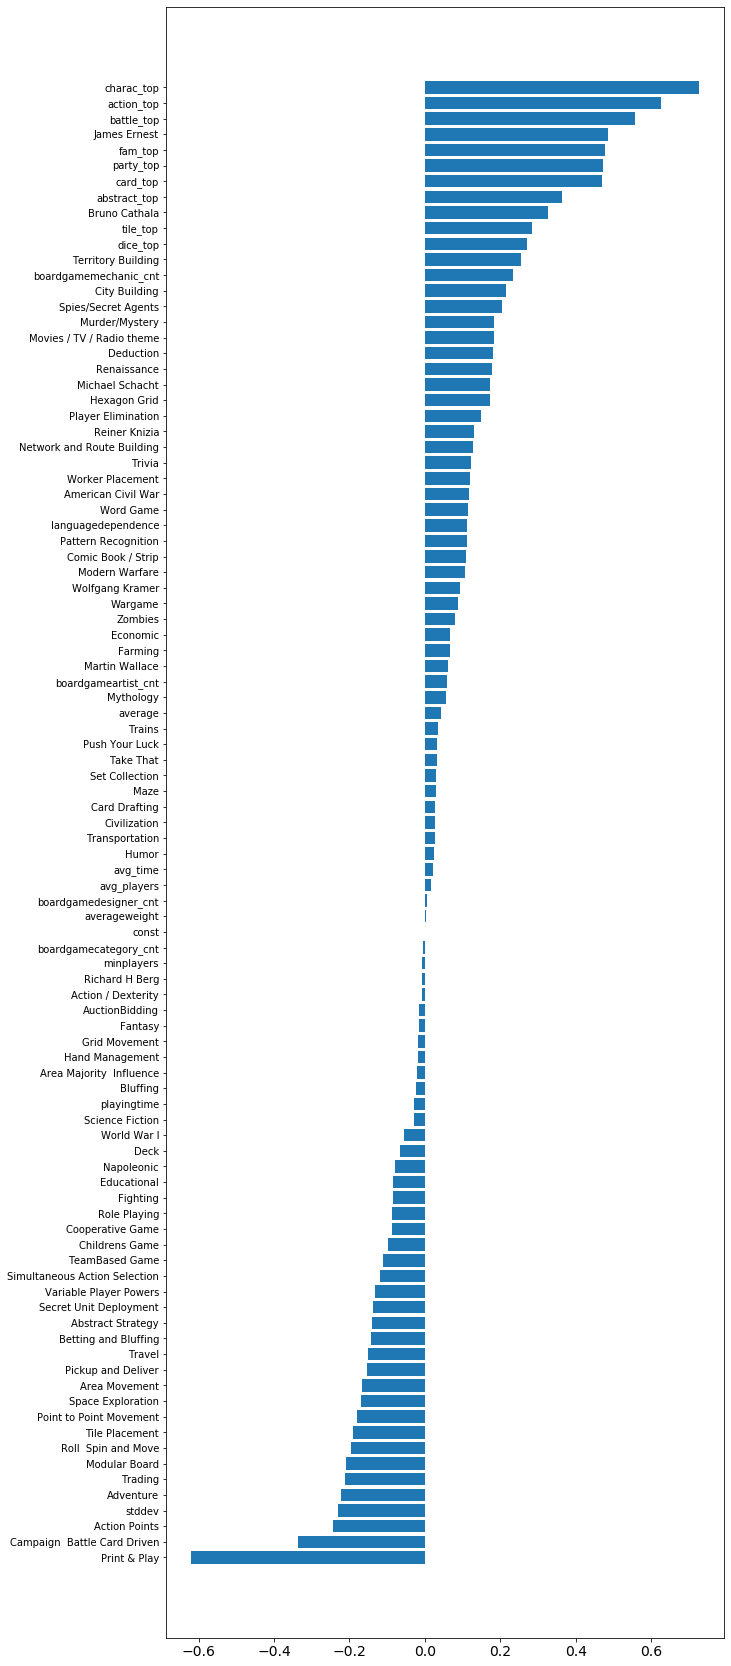

In [2269]:
# Sort feature importances in descending order
lr_indices = [x[0] for x in lr_coefs]
# Rearrange feature names so they match the sorted feature importances
lr_names = [x[1] for x in lr_coefs]
# Important as standardized so can see relative importance
plt.figure(figsize=(10,30))
plt.rc('xtick', labelsize=14)
plt.barh(lr_indices,lr_names)
plt.gca().invert_yaxis()
plt.show()
# plt.savefig('lr_featureimportance.svg');

# Random Forest Regressor

In [2298]:
rf = RandomForestRegressor()
b = rf.fit(X_train,y_train) # Fitting the model.
y_pred = b.predict(X_val) # Val set is predicted.
print(r2_score(y_val,y_pred))
print(np.sqrt(mean_squared_error(y_val,y_pred)))

0.6477472566702507
0.8066416565645375


In [2313]:
# GridSearchCV to improve Random Forest Parameters
parameters = {
            'n_estimators' : [200,400],
            'max_features': ['auto','sqrt'],
            'max_depth':[40,80,100],
            'bootstrap': [True,False],
        }

grid = GridSearchCV(rf, param_grid=parameters, scoring = 'r2', n_jobs=-1)
grid.fit(X_train,y_train)

forest = grid.best_estimator_
reg_prediction=forest.predict(X_val)

print (grid.best_score_, grid.best_params_)

0.6426709621801898 {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 400}


In [18]:
# updated with bestparams
rf = RandomForestRegressor(max_depth=100,n_estimators=400)
b = rf.fit(X_train,y_train) # Fitting the model.
y_pred = b.predict(X_val) # Val set is predicted.
print(r2_score(y_val,y_pred))
print(np.sqrt(mean_squared_error(y_val,y_pred)))

0.6522404340491472
0.8014805667342769


In [19]:
# Run on test set
y_pred_test = b.predict(X_test)
print(r2_score(y_test,y_pred_test))
# print(np.sqrt(mean_squared_error(y_test,y_pred_test)))

0.6604344639070494


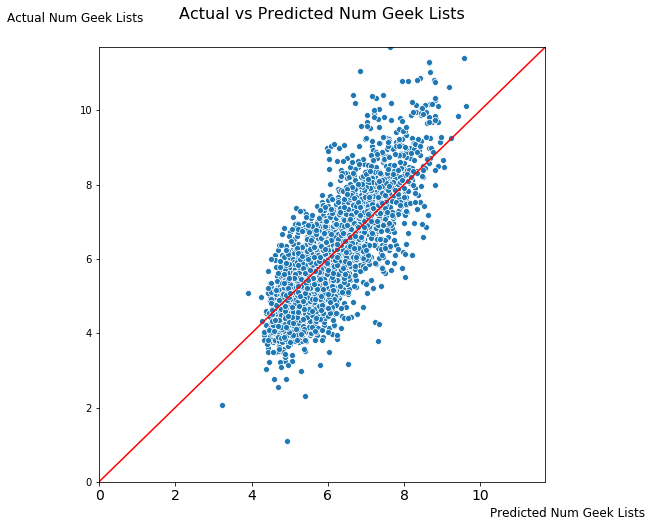

In [2282]:
# change plot for actual v predicted
plt.figure(figsize=(8,8))
sns.scatterplot(y_pred, y_val);
plt.plot([0,max(y_val)],[0, max(y_val)], color='r');
plt.ylim([0, max(y_val)]);
plt.xlim([0, max(y_val)]);

plt.ylabel('Actual Num Geek Lists', rotation = 0, fontsize = 12, y = 1.05);
plt.xlabel('Predicted Num Geek Lists', fontsize=12, x=1.05);
plt.title('Actual vs Predicted Num Geek Lists',fontsize = 16, y = 1.05);

# XGBoost Regressor

In [898]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y)

In [2272]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [2273]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_val)

[14:58:25] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [2274]:
rmse = np.sqrt(mean_squared_error(y_val, preds))
print('RMSE: %f' % (rmse))
print(r2_score(y_val,preds))

RMSE: 2.203962
-1.6296697515566576


# RF Features  - Relative Importance

In [2358]:
# using for relative importance because not unscaling
rf_coefs = list(zip(X_train.columns,rf.feature_importances_))
rf_coefs = sorted(rf_coefs, key=lambda x:x[1], reverse = True)

In [2359]:
rf_coefs

[('charac_top', 0.1254493732078011),
 ('languagedependence', 0.12169575947092884),
 ('action_top', 0.09809576612724548),
 ('stddev', 0.08992954266563331),
 ('average', 0.08612825964765232),
 ('averageweight', 0.05625588093868724),
 ('card_top', 0.04580329749445043),
 ('party_top', 0.04355484164196614),
 ('fam_top', 0.03949033180286341),
 ('boardgamemechanic_cnt', 0.039007468846366834),
 ('boardgameartist_cnt', 0.03783072998285174),
 ('battle_top', 0.037570454205364756),
 ('abstract_top', 0.02719281160175598),
 ('dice_top', 0.025469273314387506),
 ('tile_top', 0.023649814578438632),
 ('avg_players', 0.011520714618950456),
 ('avg_time', 0.010886042453122635),
 ('boardgamecategory_cnt', 0.009236248257927114),
 ('playingtime', 0.008646524338975984),
 ('boardgamedesigner_cnt', 0.0049923138047605125),
 ('minplayers', 0.003597378315173019),
 ('Print & Play', 0.0026569171397897323),
 ('Hand Management', 0.002575258501219067),
 ('Set Collection', 0.0019248178599079876),
 ('Card Drafting', 0.001

In [2368]:
def unscale_coef(coefs, scaled_cols, scales):
    '''takes in a zipped list of coefficients and list of columns that were scaled, 
    and scaler values. returns unscaled coefficients and columns'''
    new_coefs = []
    for j in coefs:
    #     j = list(j)
        col_name = j[0]
        coeff = j[1]
        if col_name in scaled_cols:
            idx = scaled_cols.index(col_name)
            coeff = (coeff / scales[idx])

    # unscaling coefficients
        j = col_name,((np.exp(coeff)-1)*100)
        new_coefs.append(j)
        
    new_coefs = sorted(new_coefs, key=lambda x:x[1], reverse = True)
    return new_coefs

In [2369]:
rf_new_coefs = unscale_coef(rf_coefs, scaled_cols,scales)
rf_new_coefs

[('charac_top', 11964.803072073288),
 ('action_top', 7596.23817452317),
 ('card_top', 461.4209679128799),
 ('party_top', 340.4504149697168),
 ('fam_top', 263.8429960290895),
 ('battle_top', 249.1940534008726),
 ('tile_top', 173.2754107824295),
 ('abstract_top', 148.55873304517044),
 ('dice_top', 116.6401565667857),
 ('stddev', 38.92060695694042),
 ('average', 9.94429139213433),
 ('languagedependence', 9.177455794587331),
 ('averageweight', 6.910507002231792),
 ('boardgamemechanic_cnt', 2.2861634331117875),
 ('boardgamecategory_cnt', 0.6886414215628633),
 ('boardgamedesigner_cnt', 0.6303800972476514),
 ('boardgameartist_cnt', 0.6223198751325931),
 ('minplayers', 0.53694041650163),
 ('Print & Play', 0.2660449872166515),
 ('Hand Management', 0.25785773277269275),
 ('Set Collection', 0.19266715109276245),
 ('Card Drafting', 0.16347057703303136),
 ('Take That', 0.1591274624138439),
 ('Area Majority  Influence', 0.15703414235890278),
 ('Fantasy', 0.15400967170111635),
 ('avg_players', 0.1437

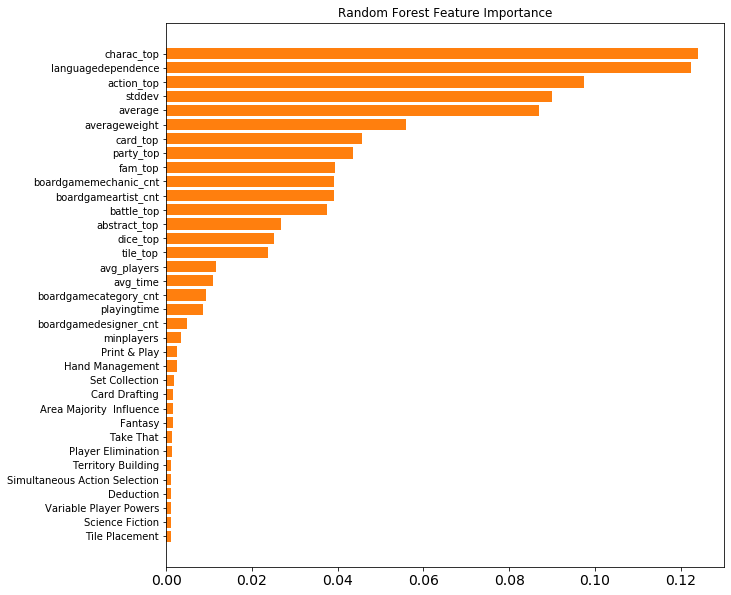

In [2327]:
# Sort feature importances in descending order
# Plotted with scaled features for relative importance
importances = np.exp(rf.feature_importances_)
indices = [x[0] for x in rf_coefs]
# Rearrange feature names so they match the sorted feature importances
names = [x[1] for x in rf_coefs]

# Create plot
plt.figure(figsize=(10,10))

# Create plot title
plt.title('Random Forest Feature Importance')

# Add bars
plt.barh(indices[0:35],names[0:35], color='tab:orange')
plt.gca().invert_yaxis()
plt.savefig('rf_featureimp.svg',format='svg',transparent=True)
plt.show()

# LR Coefficients - Unscaling

In [2362]:
# scales = list(zip(scaled_cols, scaler.scale_))
scales = list(scaler.scale_)
# scales = [np.exp(scale[1]) if scale[0] in log_cols else scale[1] for scale in scales]
coefs = list(zip(X_train.columns, lr.coef_))
# scales = [np.exp(scale[1]) if scale[0] in scaled_cols else np.exp(scale[1]) for scale in scales]
new_coefs = []
for j in coefs:
#     j = list(j)
    col_name = j[0]
    coeff = j[1]
    if col_name in scaled_cols:
        idx = scaled_cols.index(col_name)
        coeff = (coeff / scales[idx])

# unscaling coefficients
    j = col_name,((np.exp(coeff)-1)*100)
    new_coefs.append(j)

In [2363]:
coefs = sorted(new_coefs, key=lambda x:x[1], reverse = True)
coefs

[('charac_top', 110096633564116.75),
 ('action_top', 109535668825740.53),
 ('battle_top', 10870295706.160944),
 ('card_top', 4924846889.773751),
 ('party_top', 950143229.4187514),
 ('fam_top', 615086508.4729055),
 ('abstract_top', 18977861.54594646),
 ('tile_top', 17572467.10867064),
 ('dice_top', 378914.6296799879),
 ('James Ernest', 62.48491516213799),
 ('Bruno Cathala', 38.44717326961744),
 ('Territory Building', 28.91483599691287),
 ('City Building', 23.985527243098193),
 ('Spies/Secret Agents', 22.60583478335294),
 ('Murder/Mystery', 20.109219958583125),
 ('Movies / TV / Radio theme', 19.995913706425238),
 ('Deduction', 19.656085759410182),
 ('Renaissance', 19.375095064200877),
 ('Michael Schacht', 18.915354349399614),
 ('Hexagon Grid', 18.71093164837849),
 ('Player Elimination', 16.166291076693028),
 ('boardgamemechanic_cnt', 14.457056060465145),
 ('Reiner Knizia', 13.873684564645083),
 ('Network and Route Building', 13.61536318046539),
 ('Trivia', 13.057322226213541),
 ('Worker 

# Plotting Actual v Predicted - Unscaled

In [21]:
# importing pickle files with model that has Media features
# used as a comparison to show influence of media in predicting success of game
with open('y_pred_media', 'rb') as read_file:
    unscaled_y_pred_media = pickle.load(read_file)
with open('y_test_media', 'rb') as read_file:
    unscaled_y_test_media = pickle.load(read_file)

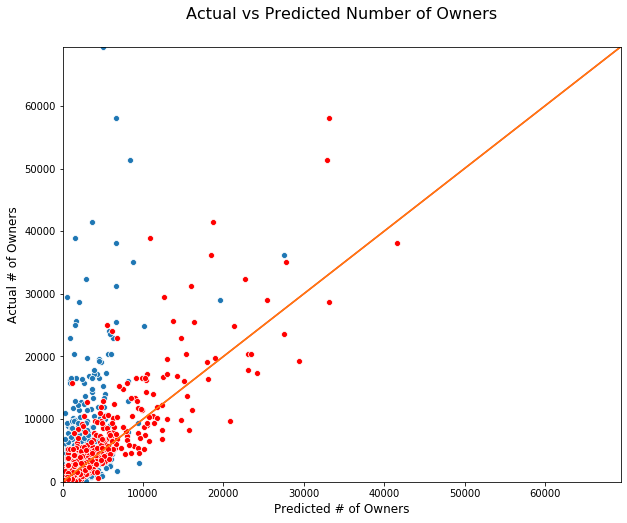

In [23]:
# plotting media and without_media predictions
unscaled_y_pred_test = np.exp(y_pred_test)
unscaled_y_test = np.exp(y_test)
# unscaled_resids = unscaled_y_test - unscaled_y_pred

plt.figure(figsize=(10,8))
sns.scatterplot(unscaled_y_pred_test, unscaled_y_test)
sns.scatterplot(unscaled_y_pred_media, unscaled_y_test_media, color='red');
plt.plot([0,max(unscaled_y_test_media)],[0,max(unscaled_y_test_media)],color='red')
plt.plot([0,max(unscaled_y_test)],[0, max(unscaled_y_test)], color='tab:orange');
plt.ylim([0, max(unscaled_y_test)]);
plt.xlim([0, max(unscaled_y_test)]);

plt.ylabel('Actual # of Owners', fontsize = 12);
plt.xlabel('Predicted # of Owners', fontsize=12);
plt.title('Actual vs Predicted Number of Owners',fontsize = 16, y = 1.05);
plt.savefig('mediavsnomedia_AvP.svg',format='svg',transparent=True)

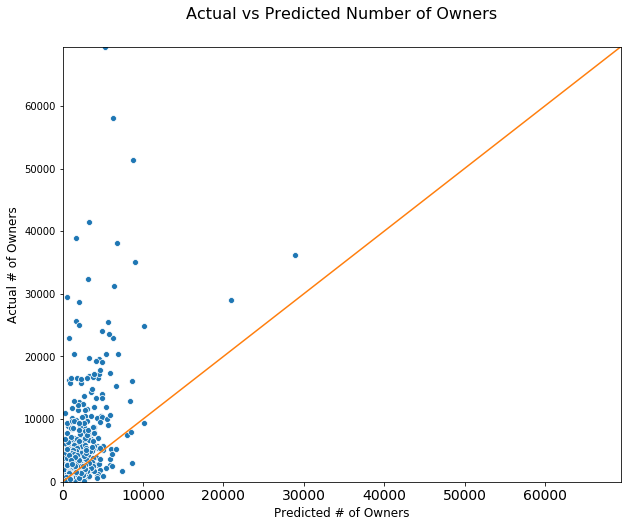

In [2326]:
# plotting the model without media influence only
unscaled_y_pred_test = np.exp(y_pred_test)
unscaled_y_test = np.exp(y_test)
# unscaled_resids = unscaled_y_test - unscaled_y_pred

plt.figure(figsize=(10,8))
sns.scatterplot(unscaled_y_pred_test, unscaled_y_test)
sns.scatterplot(unscaled_y_pred_media, unscaled_y_test_media, color='red');
plt.plot([0,max(unscaled_y_pred_media)],[0,max(unscaled_y_test_media)],color='red')
plt.plot([0,max(unscaled_y_test)],[0, max(unscaled_y_test)], color='tab:orange');
plt.ylim([0, max(unscaled_y_test)]);
plt.xlim([0, max(unscaled_y_test)]);

plt.ylabel('Actual # of Owners', fontsize = 12);
plt.xlabel('Predicted # of Owners', fontsize=12);
plt.title('Actual vs Predicted Number of Owners',fontsize = 16, y = 1.05);
# plt.savefig('actpredNOPR.svg',format='svg',transparent=True)

In [2324]:
# unscaled RMSE
print(np.sqrt(mean_squared_error(unscaled_y_pred_test, unscaled_y_test)))

2936.1044301995566


In [2371]:
# unscaled MAE
print(mean_absolute_error(unscaled_y_pred_test, unscaled_y_test))

745.1789931907233


In [ ]:
unscaled_y_pred = np.exp(y_pred)
unscaled_y_test = np.exp(y_val)
unscaled_resids = unscaled_y_test - unscaled_y_pred

resid_z_scores = (unscaled_resids-np.mean(unscaled_resids))/np.std(unscaled_resids)

plt.figure(figsize=(8,8))
sns.scatterplot(unscaled_y_pred, resid_z_scores);

plt.ylabel('Residuals\nin Z Scores', rotation = 0, fontsize = 12, y = 1.05);
plt.xlabel('Predicted Num of Owners', fontsize=12, x=1.05);
plt.title('Residuals vs Predicted Num of Owners',fontsize = 16, y = 1.05);
plt.plot([0, max(unscaled_y_pred)], [0, 0], linestyle='-', color='r');